# Preamble

In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from IPython.display import display

# Task 1: Heaps' law

In [2]:
random.seed(704)  # For reproducibility

def preprocess_text_1(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    tokens = word_tokenize(text)  
    tokens = [t for t in tokens if t not in stopwords.words("english")]  # Remove stopwords
    return tokens 

base_dir = "bbc"

#Finding the texts
text_files = []
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path): 
        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                text_files.append(os.path.join(category_path, filename))

num_samples = min(50, len(text_files))
random_files = random.sample(text_files, num_samples)

document_texts = []
for file_path in random_files:
    with open(file_path, "r", encoding="utf-8") as f:
        document_texts.append(preprocess_text_1(f.read()))


In [3]:
cumulative_sizes = []
cumulative_vocab_sizes = []
vocab_set = set()
total_words = 0

for doc in document_texts:
    total_words += len(doc)  # Adding document size to total
    vocab_set.update(doc)  # Adding new words to vocabulary

    cumulative_sizes.append(total_words)  
    cumulative_vocab_sizes.append(len(vocab_set))

df = pd.DataFrame({
    "Cumulative_Doc_Size": cumulative_sizes,
    "Cumulative_Vocab_Size": cumulative_vocab_sizes
})


,Cumulative_Doc_Size,Cumulative_Vocab_Size
0,261,187
1,700,477
2,817,550
3,936,629
4,1109,737


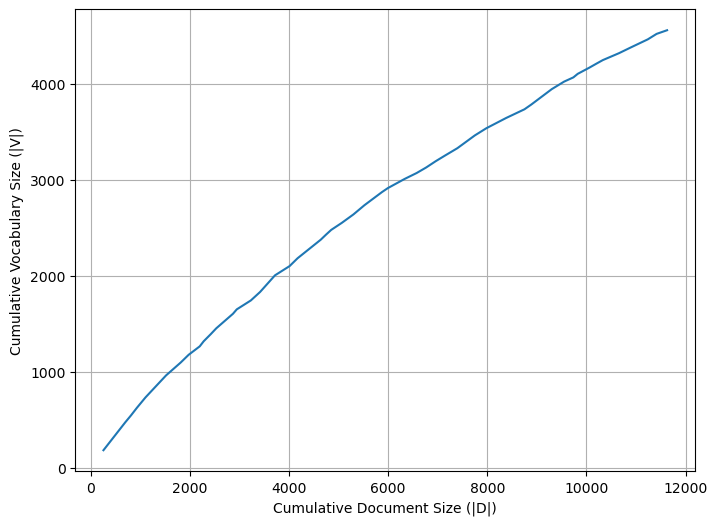

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(df["Cumulative_Doc_Size"], df["Cumulative_Vocab_Size"], linestyle='-')
plt.xlabel("Cumulative Document Size (|D|)")
plt.ylabel("Cumulative Vocabulary Size (|V|)")
plt.grid(True)
plt.show()


Estimated a: 2.4604
Estimated b: 0.8099


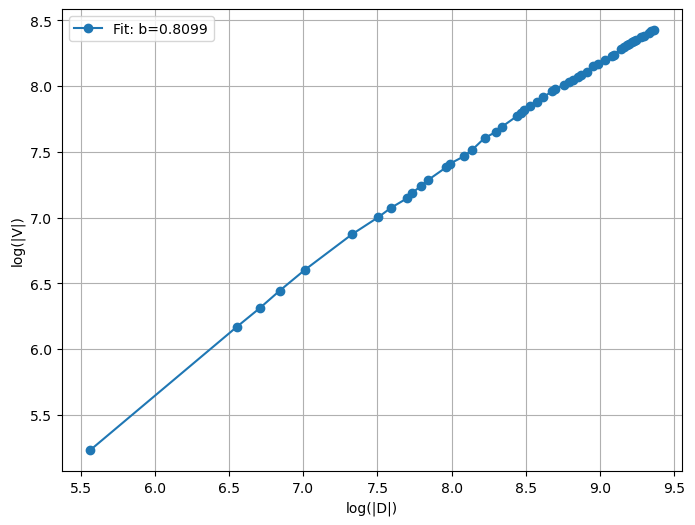

In [5]:
import numpy as np
from scipy.stats import linregress

log_D = np.log(df["Cumulative_Doc_Size"])
log_V = np.log(df["Cumulative_Vocab_Size"])

slope, intercept, r_value, _, _ = linregress(log_D, log_V)

a = np.exp(intercept) 
b = slope 

print(f"Estimated a: {a:.4f}")
print(f"Estimated b: {b:.4f}")

plt.figure(figsize=(8,6))
plt.plot(log_D, log_V, marker='o', linestyle='-', label=f"Fit: b={b:.4f}")
plt.xlabel("log(|D|)")
plt.ylabel("log(|V|)")
plt.legend()
plt.grid(True)
plt.show()


# Task 2

In [6]:
from collections import Counter

all_words = [word for doc in document_texts for word in doc]
word_freq = Counter(all_words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

zipf_df = pd.DataFrame(sorted_word_freq, columns=["Word", "Frequency"])
zipf_df["Rank"] = zipf_df.index + 1  # Rank starts from 1

,Word,Frequency,Rank
0,said,175,1
1,also,64,2
2,people,63,3
3,would,53,4
4,mr,52,5


Estimated c: 379.4340
Estimated slope (should be ~ -1): -0.7271


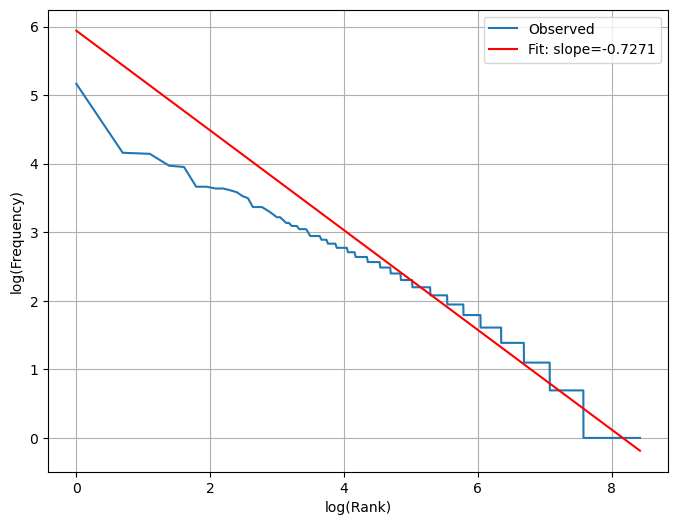

In [9]:
from scipy.stats import linregress

log_rank = np.log(zipf_df["Rank"])
log_freq = np.log(zipf_df["Frequency"])

slope, intercept, r_value, _, _ = linregress(log_rank, log_freq)
c = np.exp(intercept)  # Since log c = intercept

print(f"Estimated c: {c:.4f}")
print(f"Estimated slope (should be ~ -1): {slope:.4f}")

# Plot log-log relationship with fitted line
plt.figure(figsize=(8,6))
plt.plot(log_rank, log_freq, '-', label="Observed")
plt.plot(log_rank, slope * log_rank + intercept, 'r-', label=f"Fit: slope={slope:.4f}")
plt.xlabel("log(Rank)")
plt.ylabel("log(Frequency)")
plt.legend()
plt.grid(True)
plt.show()


# Task 3

In [10]:
with open('pg71865.txt', encoding='utf-8') as f:
    woolf_paragraphs = [p.strip() for p in f.read().split("\n\n") if p.strip()]

with open('pg7849.txt', encoding='utf-8') as f:
    kafka_paragraphs = [p.strip() for p in f.read().split("\n\n") if p.strip()]

woolf_docs = [(p, "Woolf") for p in woolf_paragraphs]
kafka_docs = [(p, "Kafka") for p in kafka_paragraphs]

In [11]:
split_woolf = int(0.8 * len(woolf_docs))
split_kafka = int(0.8 * len(kafka_docs))

woolf_train, woolf_test = woolf_docs[:split_woolf], woolf_docs[split_woolf:]
kafka_train, kafka_test = kafka_docs[:split_kafka], kafka_docs[split_kafka:]

In [12]:
#For balance
train_size = min(len(woolf_train), len(kafka_train))
test_size = min(len(woolf_test), len(kafka_test))

train_data = woolf_train[:train_size] + kafka_train[:train_size]
test_data = woolf_test[:test_size] + kafka_test[:test_size]

random.shuffle(train_data)
random.shuffle(test_data)

In [13]:
train_df = pd.DataFrame(train_data, columns=["Text", "Author"])
test_df = pd.DataFrame(test_data, columns=["Text", "Author"])


,Text,Author
0,A sound interrupted him; a frail quivering sou...,Woolf
1,This website includes information about Projec...,Kafka
2,"There was immediate silence, which showed how ...",Kafka
3,"Volubly, troublously, the late clock sounded, ...",Woolf
4,"So, thought Septimus, looking up, they are sig...",Woolf


In [14]:
def preprocess_text_2(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)  
    tokens = word_tokenize(text) 
    tokens = [t for t in tokens if t not in stopwords.words('english')] 
    return " ".join(tokens)

In [15]:
train_df["Processed_Text"] = train_df["Text"].apply(preprocess_text_2)
test_df["Processed_Text"] = test_df["Text"].apply(preprocess_text_2)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train = tfidf_vectorizer.fit_transform(train_df["Processed_Text"])
y_train = train_df["Author"] 
X_test = tfidf_vectorizer.transform(test_df["Processed_Text"])
y_test = test_df["Author"]

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

# Classifier with elastic net reg
classifier = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga", 
    l1_ratios=[0.1, 0.5, 0.9],  
    cv=5, 
    max_iter=1000  
)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(report)

Accuracy: 0.90
              precision    recall  f1-score   support

       Kafka       0.92      0.88      0.90        41
       Woolf       0.88      0.93      0.90        41

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82

